In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import seaborn as sns

np.set_printoptions(threshold=np.inf)

Using TensorFlow backend.


In [2]:
raw_data = pd.read_csv('data/train.csv')

C:\Users\Ethan\Anaconda3\envs\DS\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
raw_data.columns

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'Yards', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')

In [4]:
raw_data['Temperature'] = raw_data['Temperature'].fillna(raw_data['Temperature'].mean())
raw_data['Humidity'] = raw_data['Humidity'].fillna(raw_data['Humidity'].mean())
raw_data = raw_data.dropna()

In [5]:
plays = np.unique(raw_data['PlayId'])
plays_trn, plays_tst = train_test_split(plays, train_size=0.75)
data_trn = raw_data[raw_data['PlayId'].isin(plays_trn)]
data_tst = raw_data[raw_data['PlayId'].isin(plays_tst)]

In [16]:
P_GAIN = 5
P_BUFFER = int(60 * P_GAIN)
V_GAIN = 10
V_BUFFER = int(20 * V_GAIN)
off_p_count = np.zeros((P_BUFFER*2+1,P_BUFFER*2+1))
off_v_count = np.zeros((V_BUFFER*2+1,V_BUFFER*2+1))
def_p_count = np.zeros((P_BUFFER*2+1,P_BUFFER*2+1))
def_v_count = np.zeros((V_BUFFER*2+1,V_BUFFER*2+1))
off_p_yards = np.zeros((P_BUFFER*2+1,P_BUFFER*2+1))
off_v_yards = np.zeros((V_BUFFER*2+1,V_BUFFER*2+1))
def_p_yards = np.zeros((P_BUFFER*2+1,P_BUFFER*2+1))
def_v_yards = np.zeros((V_BUFFER*2+1,V_BUFFER*2+1))
for _,play in data_trn.groupby(['PlayId']):
    offense_team = play.loc[play['NflId'] == play['NflIdRusher'],'Team'].iloc[0]
    direction = play['PlayDirection'].iloc[0]
    yards = play['Yards'].iloc[0]
    runner = play.loc[play['NflId'] == play['NflIdRusher']]
    opx = runner['X'] * P_GAIN
    opy = runner['Y'] * P_GAIN
    ovx = runner['S'] * np.sin(np.deg2rad(runner['Dir'])) * V_GAIN
    ovy = runner['S'] * np.cos(np.deg2rad(runner['Dir'])) * V_GAIN
    for _,player in play.iterrows():
        px = int(round(player['X'] * P_GAIN - opx + P_BUFFER))
        py = int(round(player['Y'] * P_GAIN - opy + P_BUFFER))
        vx = int(round(player['S'] * np.sin(np.deg2rad(player['Dir'])) * V_GAIN - ovy + V_BUFFER))
        vy = int(round(player['S'] * np.cos(np.deg2rad(player['Dir'])) * V_GAIN - ovy + V_BUFFER))
        if direction != 'right':
            px = int(round(opx - player['X'] * P_GAIN + P_BUFFER))
            vx = int(round(ovy - player['S'] * np.sin(np.deg2rad(player['Dir'])) * V_GAIN + V_BUFFER))
        if player['Team'] == offense_team:
            off_p_count[py,px] += 1
            off_v_count[vy,vx] += 1
            off_p_yards[py,px] = off_p_yards[py,px] + (yards - off_p_yards[py,px]) / off_p_count[py,px]
            off_v_yards[vy,vx] = off_v_yards[vy,vx] + (yards - off_v_yards[vy,vx]) / off_v_count[vy,vx]
        else:
            def_p_count[py,px] += 1
            def_v_count[vy,vx] += 1
            def_p_yards[py,px] = def_p_yards[py,px] + (yards - def_p_yards[py,px]) / def_p_count[py,px]
            def_v_yards[vy,vx] = def_v_yards[vy,vx] + (yards - def_v_yards[vy,vx]) / def_v_count[vy,vx]

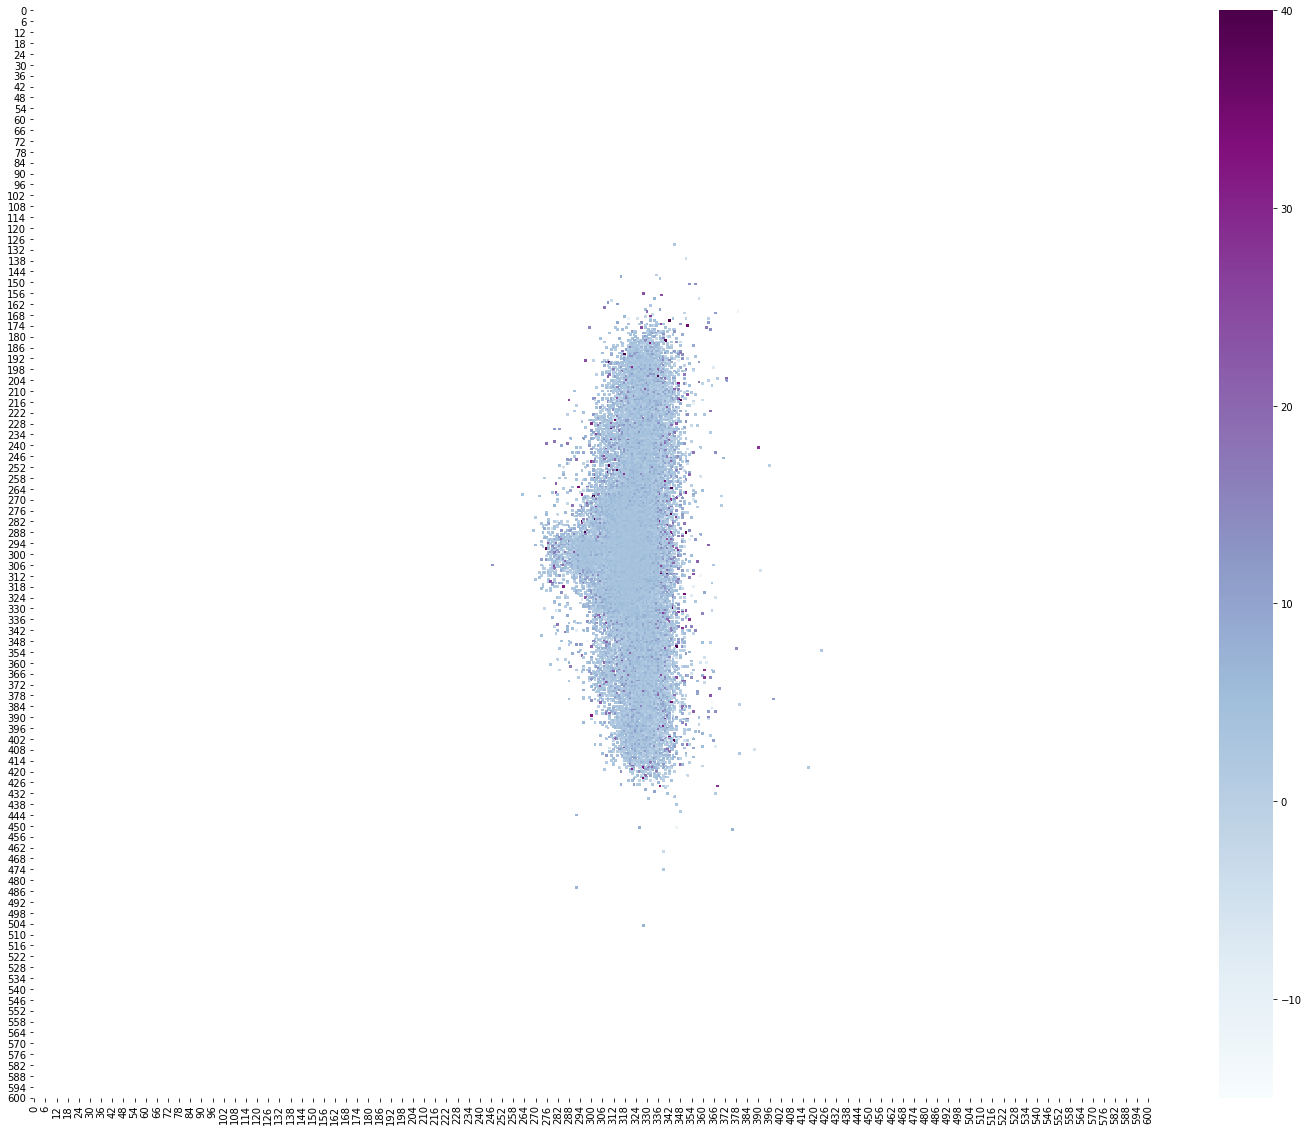

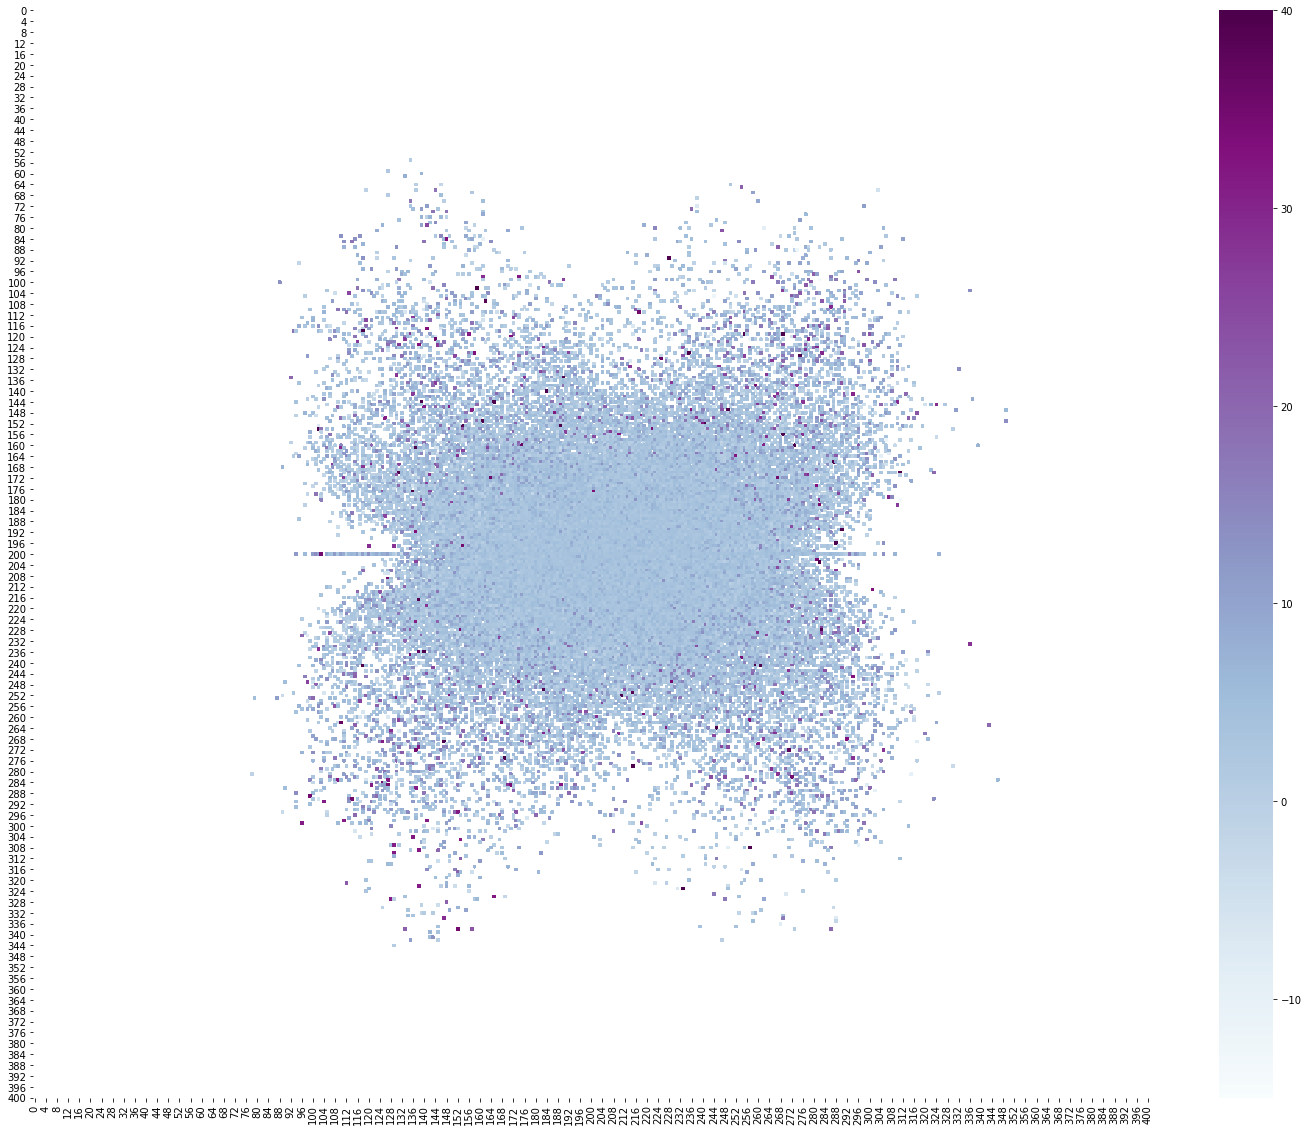

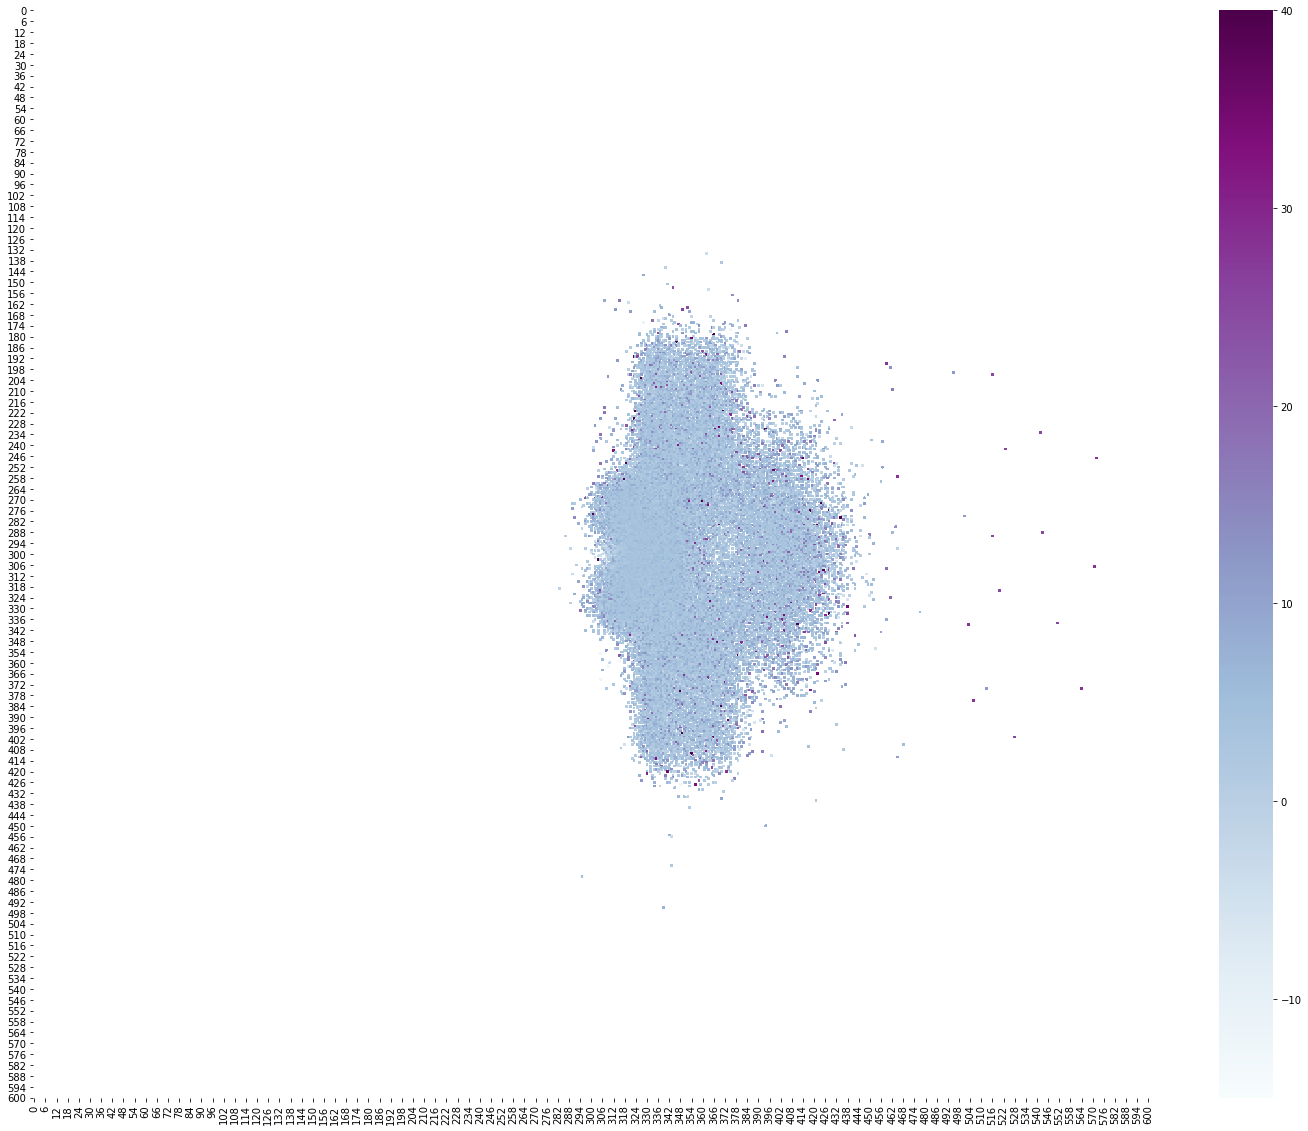

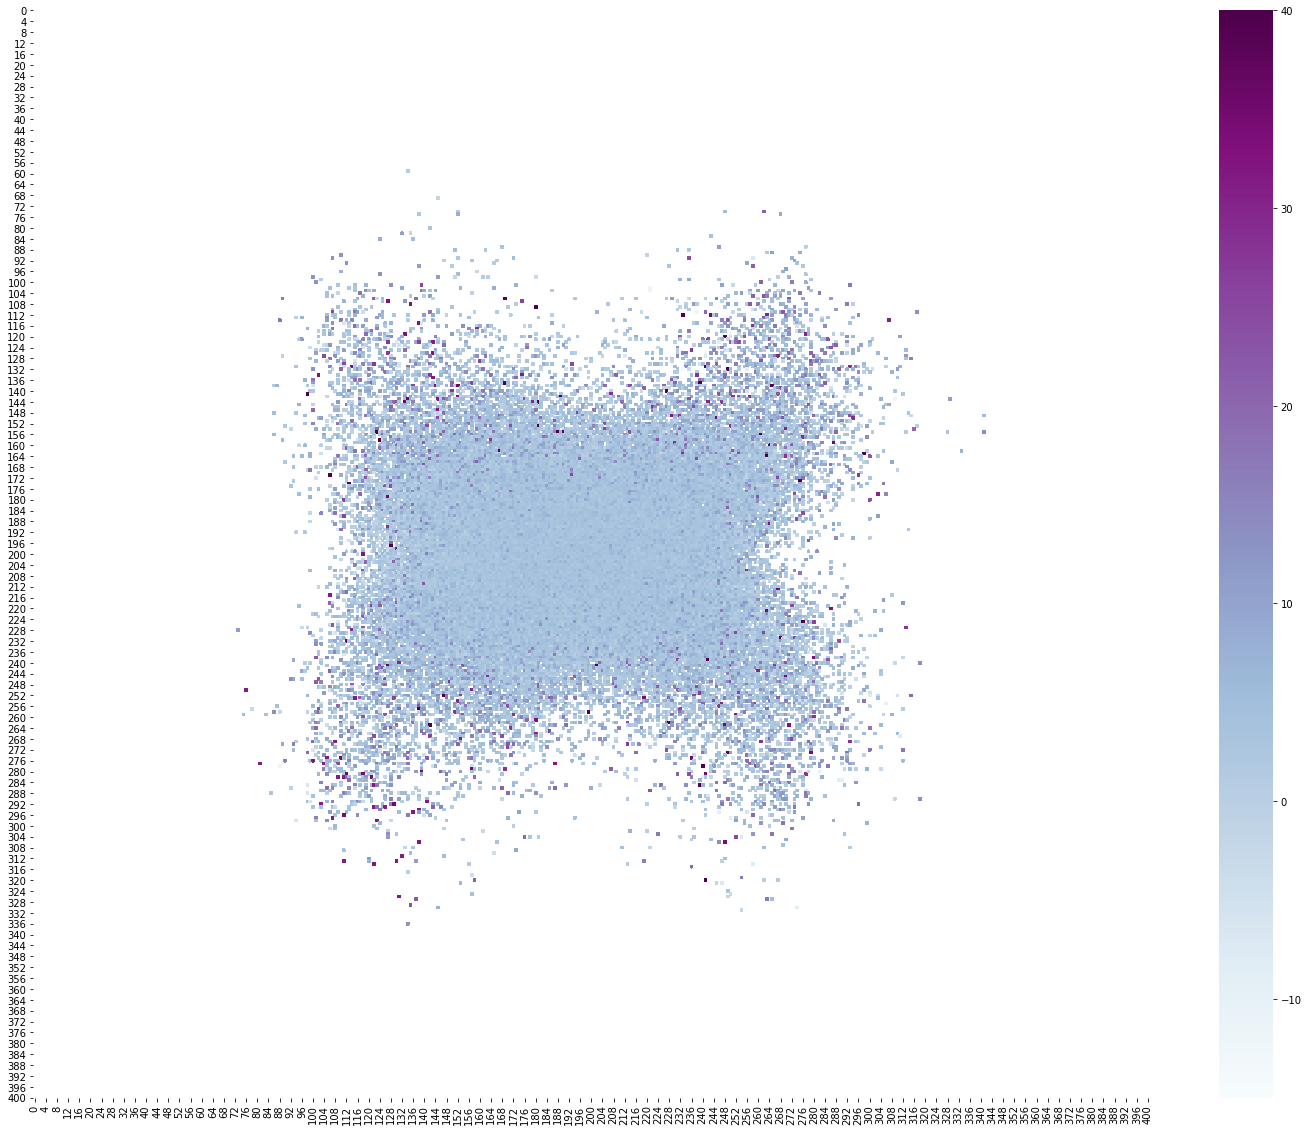

In [17]:
off_p_yards[off_p_count==0] = np.nan
off_p_fig = plt.figure(figsize=(25,20))
ax = sns.heatmap(off_p_yards,-15,40,cmap='BuPu')

off_v_yards[off_v_count==0] = np.nan
off_v_fig = plt.figure(figsize=(25,20))
ax = sns.heatmap(off_v_yards,-15,40,cmap='BuPu')

def_p_yards[def_p_count==0] = np.nan
def_p_fig = plt.figure(figsize=(25,20))
ax = sns.heatmap(def_p_yards,-15,40,cmap='BuPu')

def_v_yards[def_v_count==0] = np.nan
def_v_fig = plt.figure(figsize=(25,20))
ax = sns.heatmap(def_v_yards,-15,40,cmap='BuPu')

In [18]:
yds = []
prd = []
se = []
for _,play in data_tst.groupby(['PlayId']):
    offense_team = play.loc[play['NflId'] == play['NflIdRusher'],'Team'].iloc[0]
    direction = play['PlayDirection'].iloc[0]
    yards = play['Yards'].iloc[0]
    runner = play.loc[play['NflId'] == play['NflIdRusher']]
    opx = runner['X'] * P_GAIN
    opy = runner['Y'] * P_GAIN
    ovx = runner['S'] * np.sin(np.deg2rad(runner['Dir'])) * V_GAIN
    ovy = runner['S'] * np.cos(np.deg2rad(runner['Dir'])) * V_GAIN
    predictions = []
    weights = []
    for _,player in play.iterrows():
        px = int(round(player['X'] * P_GAIN - opx + P_BUFFER))
        py = int(round(player['Y'] * P_GAIN - opy + P_BUFFER))
        vx = int(round(player['S'] * np.sin(np.deg2rad(player['Dir'])) * V_GAIN - ovy + V_BUFFER))
        vy = int(round(player['S'] * np.cos(np.deg2rad(player['Dir'])) * V_GAIN - ovy + V_BUFFER))
        if direction != 'right':
            px = int(round(opx - player['X'] * P_GAIN + P_BUFFER))
            vx = int(round(ovy - player['S'] * np.sin(np.deg2rad(player['Dir'])) * V_GAIN + V_BUFFER))
        if player['Team'] == offense_team:
            predictions.append(off_p_yards[py,px])
            weights.append(off_p_count[py,px])
            predictions.append(off_v_yards[vy,vx])
            weights.append(off_v_count[vy,vx])
        else:
            predictions.append(def_p_yards[py,px])
            weights.append(def_p_count[py,px])
            predictions.append(def_v_yards[vy,vx])
            weights.append(def_v_count[vy,vx])
    prediction = np.average(predictions, weights=weights)
    yds.append(yards)
    prd.append(prediction)
    se.append((prediction-yards)*(prediction-yards))
print('mse: ' + str(np.mean(se)))

mse: nan


<function matplotlib.pyplot.show(*args, **kw)>

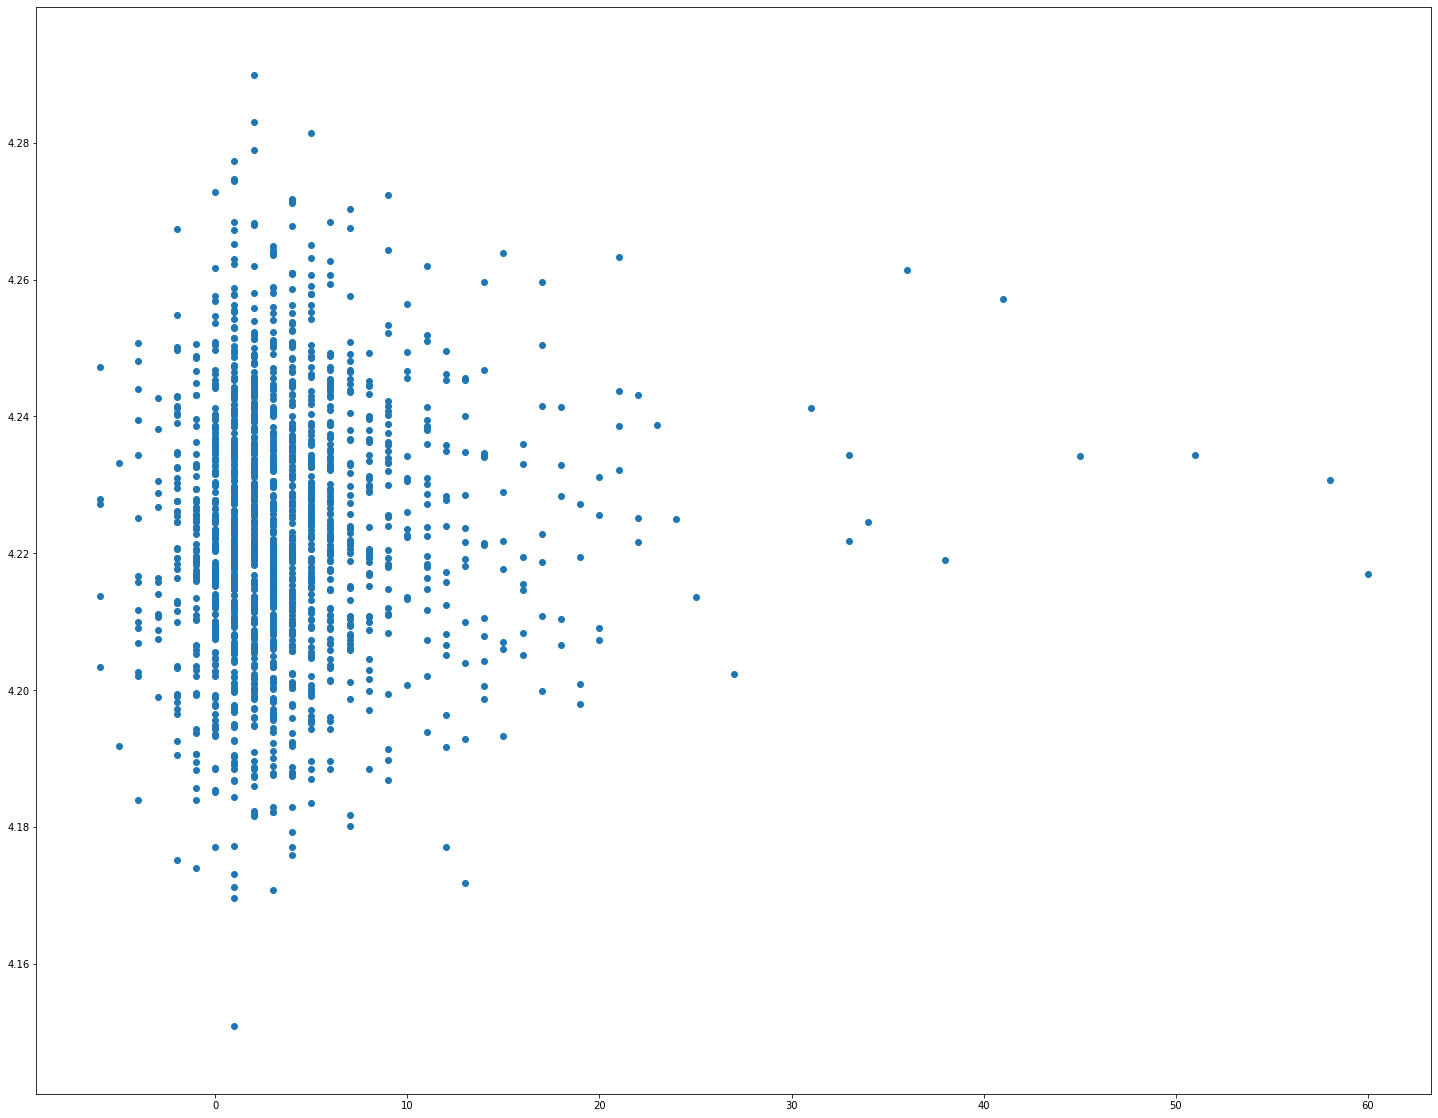

In [19]:
plt.figure(figsize=(25,20))
plt.scatter(yds,prd)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

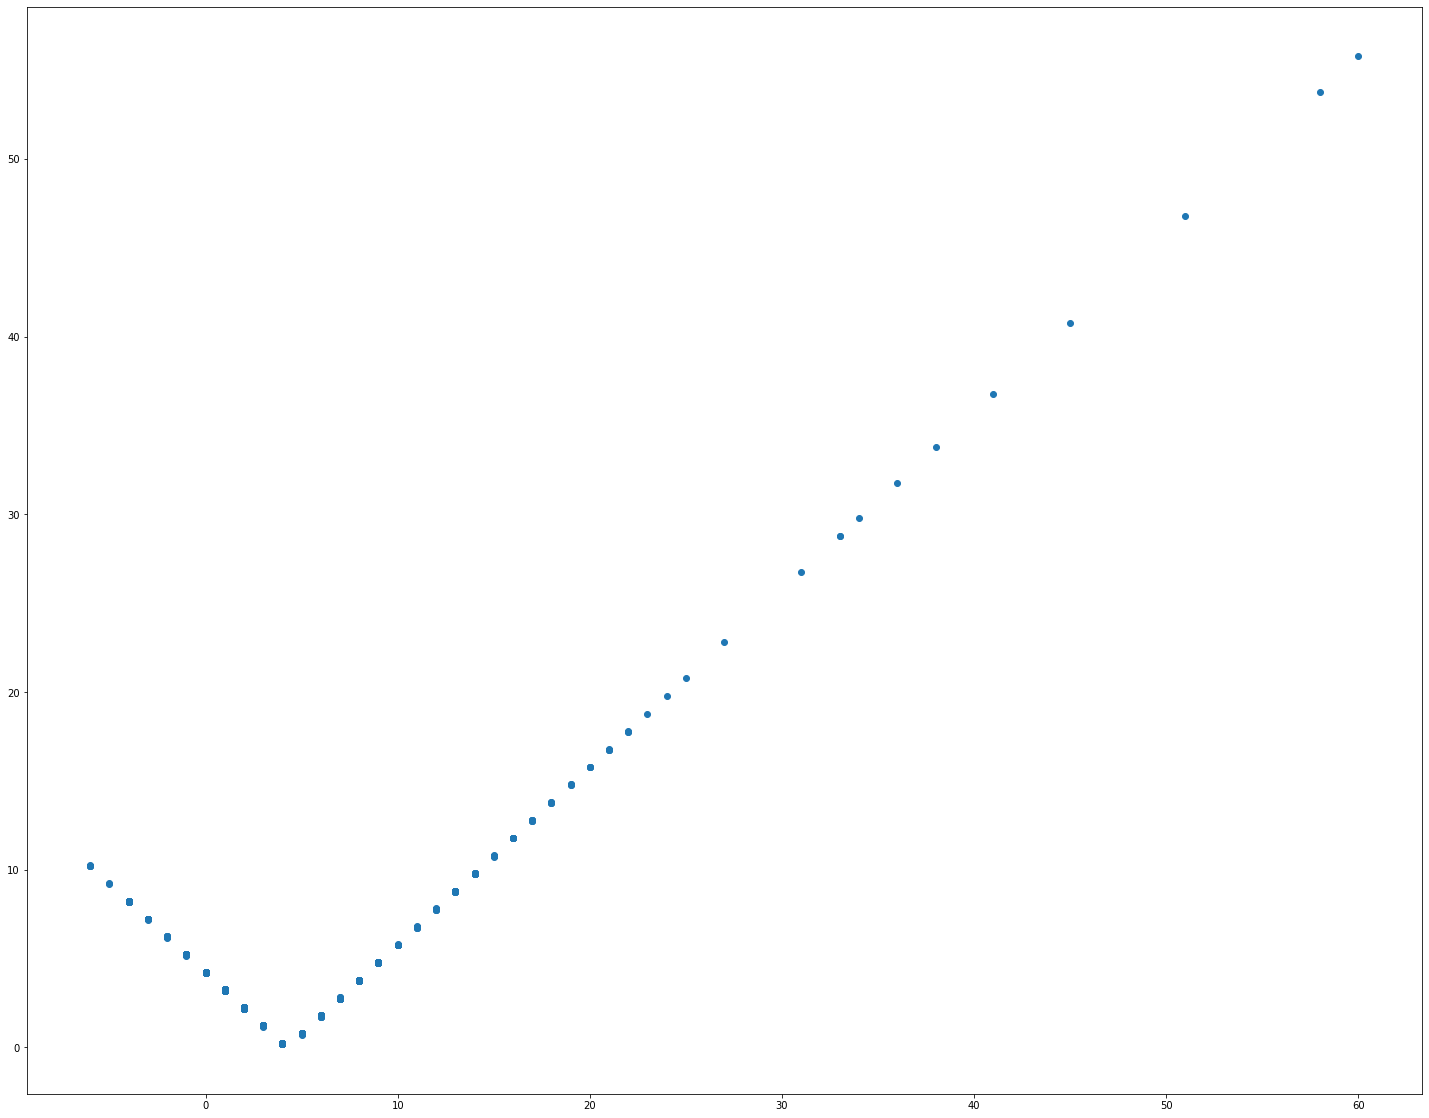

In [20]:
plt.figure(figsize=(25,20))
plt.scatter(yds,np.sqrt(se))
plt.show